# Mean Shift

> Mean shift is a non-parametric feature-space analysis technique for locating the maxima of a density function, a so-called mode-seeking algorithm.

## Table of Contents

[**Introduction**](#Introduction)

[**I - Algorithm Steps**](#I---Algorithm-steps)
* [**A - Kernel Density Estimation**](#A---Kernel-Density-Estimation)
* [**B - Mean Shift**](#B---Mean-Shift)
* [**C - Prediction and classification**](#C---Prediction-and-classification)

[**Conclusion**](#Conclusion)

[**Sources**](#Sources)

## Introduction 


As opposed to K-Means, when using **Mean Shift**, you don’t need to know the number of clusters beforehand. 
The number of clusters is **determined by the algorithm** with the data.
Be aware, mean shift is **expensive : O(n²)**

Data points to the clusters are shifted iteratively towards the mode (which is the highest density of data points in the region). 
Mean-shift algorithm has applications in **image processing** and **computer vision**.

## I - Algorithm steps

### A - Kernel Density Estimation

You need to represent your data in a mathematical manner which means that your data **must be represented as points**. You need to define a **window** and place it **on your data points**. 
Next step will be to **compute the mean** for all the points in the window.

Mean Shift is build upon **kernel density estimation**.

<table>
    <tbody>
        <tr>
            <td><img width="50px" src="https://image.flaticon.com/icons/png/512/2933/2933228.png" alt="book"/></td>
            <td><b>Kernel Density estimation</b> is a non-parametric method for estimating the probability density of a set of data.</td>
        </tr>
    </tbody>
</table>

It works by **placing a kernel** (the most popular is the Gaussian one) **on each point in the data set**. Adding up all of the individual kernels generates a **probability surface example density function**. Depending on the kernel **bandwidth parameter** used, the resultant density function will vary.

Formula of the **Gaussian kernel** : $k(x)$= $e^{-{\frac {x^{2}}{2\sigma ^{2}}}}$ where the standard deviation parameter $\sigma$ works as the bandwidth parameter $h$.

Function for determining the **weight of nearby points** for re-estimation of the mean : 
$$K(x_i - x) = e^{-c||x_i - x||^2}$$ 

The **weighted mean of the density in the window** determined by $K$ is

$$m(x)= \frac{\sum _{x_{i}\in N(x)}K(x_{i}-x)x_{i}}{\sum _{x_{i}\in N(x)}K(x_{i}-x)}$$


where $N(x)$ is the neighborhood of $x$, a set of points for which ${K(x_{i})\neq 0}$.

The difference $m(x)-x$ is called **mean shift**. The mean-shift algorithm now sets $x \leftarrow m(x)$ and repeats the estimation until $m(x)$ converges.


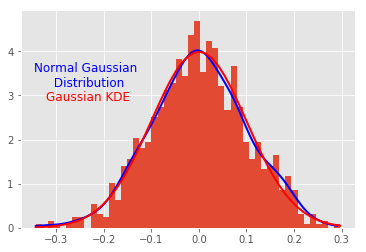

In [7]:
## On this graph, you can see the difference between a normal gaussian distribution and the gaussian KDE

from scipy.stats.kde import gaussian_kde
from scipy.stats import norm

import numpy as np
import matplotlib.pyplot as plt

mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)

funct = gaussian_kde(s)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

count, bins, ignored = plt.hist(s, 50, density=True)

len_bins = len(bins)
resol = (bins[len_bins-1] - bins[0]) / 100.0
x = np.arange(bins[0],bins[len_bins-1],resol)

plt.text(0.2, 0.6,'Gaussian KDE',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes, fontsize=12,color='r')

plt.text(0.2, 0.7,'Normal Gaussian \n Distribution',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes, fontsize=12,color='b')

plt.plot(x,funct(x), linewidth=2, color='b') 
plt.plot(bins, norm.pdf(bins, mu,sigma), linewidth=2, color='r')

plt.show()

### B - Mean Shift

Mean shift use the **KDE** by imagining what the points would do if they all climbed up hill to the **nearest peak** on the KDE surface. It does so by **iteratively shifting each point** until it reaches a peak.

The basic method of mean shift is : 

- Make all datapoints centroids
- Take mean of all featuresets within centroid's radius, setting this mean as new centroid.
- Repeat step 2 until convergence.

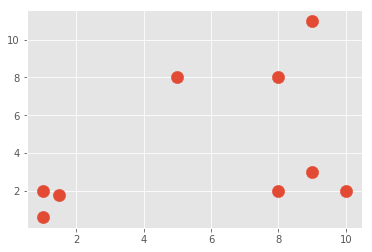

In [8]:
## Creation of data

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import numpy as np

X = np.array([[1, 2],
              [1.5, 1.8],
              [5, 8 ],
              [8, 8],
              [1, 0.6],
              [9,11],
              [8,2],
              [10,2],
              [9,3],])

plt.scatter(X[:,0], X[:,1], s=150)
plt.show()

colors = 10*["g","r","c","b","k"]

In [9]:
#Creation of the class Mean Shift that represents the algorithm
class Mean_Shift:
    #the radius must be dynamic, otherwise the algorithm is weak
    def __init__(self, radius= None, radius_norm_step = 100):
        self.radius = radius
        self.radius_norm_step = radius_norm_step

    def fit(self, data):
        #make that radius go in steps, like bandwidths
        # if a featureset is in the closest radius, it will have a much higher "weight" than one much further away
        if self.radius == None:
            all_data_centroid = np.average(data, axis=0)
            all_data_norm = np.linalg.norm(all_data_centroid)
            self.radius = all_data_norm / self.radius_norm_step
        
        centroids = {}

        #Step one
        for i in range(len(data)):
            centroids[i] = data[i]
            
        # step two until convergence 
        # iterating through each centroid, and finding all featuresets in range. 
        # From there, we are taking the average, and setting that average as the "new centroid." 
        # Finally, we're creating a unique variable, which tracks the sorted list of all known centroids. 
        
        #we need to define weights : how many "radius steps" a featureset is from the centroid
        #treating them as index values for the weight list.
        weights = [i for i in range(self.radius_norm_step)][::-1]
        while True:
            new_centroids = []
            for i in centroids:
                in_bandwidth = []
                centroid = centroids[i]
                for featureset in data: 
                    distance = np.linalg.norm(featureset-centroid)
                    if distance == 0:
                        distance = 0.00000000001
                    weight_index = int(distance/self.radius)
                    if weight_index > self.radius_norm_step-1:
                        weight_index = self.radius_norm_step-1

                    to_add = (weights[weight_index]**2)*[featureset]
                    in_bandwidth +=to_add
                    
                new_centroid = np.average(in_bandwidth,axis=0)
                new_centroids.append(tuple(new_centroid))

            uniques = sorted(list(set(new_centroids)))
            
            # We need to merge centroids that are close
            to_pop = []

            for i in uniques:
                for j in [i for i in uniques]:
                    if i == j:
                        pass
                    elif np.linalg.norm(np.array(i)-np.array(j)) <= self.radius:
                        to_pop.append(j)
                        break

            for i in to_pop:
                try:
                    uniques.remove(i)
                except:
                    pass
                
            prev_centroids = dict(centroids)

            centroids = {}
            for i in range(len(uniques)):
                centroids[i] = np.array(uniques[i])

            optimized = True

            for i in centroids:
                if not np.array_equal(centroids[i], prev_centroids[i]):
                    optimized = False
                if not optimized:
                    break
                
            if optimized:
                break

        self.centroids = centroids
        
        self.classifications = {}

        for i in range(len(self.centroids)):
            self.classifications[i] = []
            
        for featureset in data:
            #compare distance to either centroid
            distances = [np.linalg.norm(featureset-self.centroids[centroid]) for centroid in self.centroids]
            #print(distances)
            classification = (distances.index(min(distances)))

            # featureset that belongs to that cluster
            self.classifications[classification].append(featureset)

### C - Prediction and classification

Imagine that you have a set of points and each of them represent one of your class : calculous, AI, machine learning. You don't know which points belongs to one of your class (you don't have labels).

After clustering your data, you need to classify them in order to know their belongings.

In [10]:
# We can now predict our data
def predict(self,data):
    #compare distance to either centroid
    distances = [np.linalg.norm(data-self.centroids[centroid]) for centroid in self.centroids]
    classification = (distances.index(min(distances)))
    return classification

{0: array([1.18211438, 1.50109686]), 1: array([7.45598917, 8.44263203]), 2: array([8.97302521, 2.50551952])}


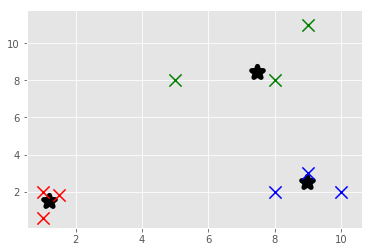

In [11]:
clf = Mean_Shift()
clf.fit(X)

centroids = clf.centroids
print(centroids)

colors = 10*['r','g','b','c','k','y']

# let's classify our dataset
for classification in clf.classifications:
    color = colors[classification]
    for featureset in clf.classifications[classification]:
        plt.scatter(featureset[0],featureset[1], marker = "x", color=color, s=150, linewidths = 5, zorder = 10)

for c in centroids:
    plt.scatter(centroids[c][0],centroids[c][1], color='k', marker = "*", s=150, linewidths = 5)

plt.show()

We did the implementation of Mean Shift on our own. As Python is well done, you can always use scikit-learn library and the method **sklearn.cluster.MeanShift** that you'll find here : https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html

It is always way better to use things that are already implemented because people who did this surely code better than us (and it is actually more optimized).

## Conclusion

Mean Shift algorithm is model-free, it doesn’t assume any prior shape like spherical or elliptical on data clusters. Unfortunatly, it doesn’t scale well with dimension of feature space and the output depends on window size. However, it just needs a single parameter (**window size h**) where h has a **physical meaning**, which can be a better choice than K-Means.

Mean Shift can also be used for **tracking** and **smoothing**.

## 📖 Sources

### Websites

| Name | Author | Date | Description |
| --- | --- | --- | --- |
| [towardsdatascience](https://towardsdatascience.com/machine-learning-algorithms-part-13-mean-shift-clustering-example-in-python-4d6452720b00) | Cory Maklin | 2018 | Explanation on Mean Shift Clustering Algorithm |
| [geeksforgeeks](https://www.geeksforgeeks.org/ml-mean-shift-clustering/) | Ankurtripathi | 2020 | Explanation on Mean Shift Clustering Algorithm and KDE|